# Topic Modeling based on Digitised Volumes of theatrical English, Scottish, and Irish playbills between 1600 - 1902 from data.bl.uk

Topic Models are a type of statistical language models used for discovering hidden structure in a collection of texts. 

This example is based on the a dataset that comprises 264 volumes of digitised theatrical playbills published between 1660 – 1902 (mostly 19th century) from England, Scotland, Wales and Ireland. Digitised from the British Library's physical collection of over 500 volumes of playbills. The dataset contains text files (.TXT) in Optical Character Recognition (OCR) format. More information about the dataset at https://data.bl.uk/playbills/

## Setting up things

In [26]:
import sys
import os
import requests
import pandas as pd
import re
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/gustavo/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Reading the CSV file

**Note:** the original dataset did not include a CSV file. It was generated from the Excel file.

In [27]:
# Read data into playbills
playbills = pd.read_csv('playbills-ocr-text/playbills.csv', encoding='iso-8859-1')

# Print head
playbills.head()

,Ingestion Order,Shelf Mark,Volume,PID,Create Date,File Name (.PDF),Path,File Size (MB),LSID
0,2,Playbills 1,Playbills 1,373904,3 de sep de 10,015376973_313_Playbills 1,/2010/09/03/file_1/373904,"156,38",3f9b9a08
1,12,Playbills 10,Playbills 10,379308,7 de sep de 10,014933523_1305_Playbills 10,/2010/09/07/file_4/379308,"185,7",3f9c9e0f
2,101,Playbills 100,Playbills 100,435983,21 de sep de 10,015176783_1333_Playbills 100,/2010/09/21/file_6/435983,"294,12",400ce74c
3,103,Playbills 101,Playbills 101 (1),436802,21 de sep de 10,015176791_2150_Playbills 101 (1),/2010/09/21/file_7/436802,"70,98",400ce5c3
4,105,Playbills 101,Playbills 101 (2),437629,21 de sep de 10,015176791_2975_Playbills 101 (2),/2010/09/21/file_8/437629,"75,05",400c8a20


## Data cleaning

Since the goal of this analysis is to perform topic modeling, we will focus on the text data from each register, and remove other metadata columns that are not necessary.

In [29]:
# Remove the columns
playbills = playbills.drop(columns=['Ingestion Order', 'Shelf Mark', 'PID', 'Path', 'File Name (.PDF)', 'File Size (MB)'], axis=1)# Print out the first rows of papers
playbills.head()

,Volume,Create Date,LSID
0,Playbills 1,3 de sep de 10,3f9b9a08
1,Playbills 10,7 de sep de 10,3f9c9e0f
2,Playbills 100,21 de sep de 10,400ce74c
3,Playbills 101 (1),21 de sep de 10,400ce5c3
4,Playbills 101 (2),21 de sep de 10,400c8a20


## Remove punctuation/lower casing/stopwords

Next, let’s perform a simple preprocessing on the content to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, lowercase the text, remove stopwords and then remove non English words since the OCR may have some errors.

We use wordnet to verify if the word exists. We also have added some specific stopwords to enhance the performance.

In [52]:
# adding specific stopwords
stop_words = ["mr", "mrs", "miss", "sir", "it", "will", "mi", "hi", "th", "co", "ee", "oh"] + list(STOPWORDS)
STOPWORDS

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 

In [47]:
texts = []

for index,row in playbills.iterrows():
    
    
    try:
        file = "playbills-ocr-text/lsidyv"+ row['LSID'] +".txt";
        print(file)
        f = open(file, "r")

        text = f.read()

        # remove_digits and special chars
        pattern = r'[^a-zA-Z\s]' 
        text = re.sub(pattern, '', text)

        # Convert the titles to lowercase
        text = text.lower()
        
        filtered_text = [] 
          
        tokens = word_tokenize(text)
        for token in tokens:

            if len(token) == 1:
                continue
            elif token in stop_words:
                continue
            elif not wordnet.synsets(token):
                #Not an English Word
                continue
            else:
                #English Word
                filtered_text.append(token)
        
        texts=(', '.join(filtered_text))
    except:
        print("An exception occurred", sys.exc_info()[0]) 
        texts = ''

# add a new column with text        
playbills['paper_text_processed'] = texts

[Synset('southwest.n.01')]
playbills-ocr-text/lsidyv3f9b9a08.txt
playbills-ocr-text/lsidyv3f9c9e0f.txt
playbills-ocr-text/lsidyv400ce74c.txt
playbills-ocr-text/lsidyv400ce5c3.txt
playbills-ocr-text/lsidyv400c8a20.txt
playbills-ocr-text/lsidyv400cedb2.txt
playbills-ocr-text/lsidyv400ce91e.txt
playbills-ocr-text/lsidyv400cea84.txt
playbills-ocr-text/lsidyv400cef81.txt
playbills-ocr-text/lsidyv400e6f9f.txt
playbills-ocr-text/lsidyv400e71ef.txt
playbills-ocr-text/lsidyv400e6de9.txt
playbills-ocr-text/lsidyv400e70d8.txt
playbills-ocr-text/lsidyv400d85a1.txt
playbills-ocr-text/lsidyv4045b65a.txt
playbills-ocr-text/lsidyv3f9ca137.txt
playbills-ocr-text/lsidyv4045aa38.txt
playbills-ocr-text/lsidyv4045b543.txt
playbills-ocr-text/lsidyv4045ad2a.txt
playbills-ocr-text/lsidyv4045ae7b.txt
playbills-ocr-text/lsidyv40459c5e.txt
playbills-ocr-text/lsidyv4045a8a9.txt
playbills-ocr-text/lsidyv4045ab5a.txt
playbills-ocr-text/lsidyv4045b355.txt
playbills-ocr-text/lsidyv4045a654.txt
playbills-ocr-text/lsid

playbills-ocr-text/lsidyv3fa2d31b.txt
playbills-ocr-text/lsidyv3f9dcba3.txt
playbills-ocr-text/lsidyv3f9dd9e6.txt
playbills-ocr-text/lsidyv3f9dce90.txt
playbills-ocr-text/lsidyv3f9dd4e6.txt
playbills-ocr-text/lsidyv3f9ddee3.txt
playbills-ocr-text/lsidyv3f9dc9bb.txt
playbills-ocr-text/lsidyv3f9dd0f5.txt
playbills-ocr-text/lsidyv3f9c41ce.txt
playbills-ocr-text/lsidyv3fa2daab.txt
playbills-ocr-text/lsidyv3fa2d459.txt
playbills-ocr-text/lsidyv3f9dd8eb.txt
playbills-ocr-text/lsidyv40009634.txt
playbills-ocr-text/lsidyv400093aa.txt
playbills-ocr-text/lsidyv3f9dcaac.txt
playbills-ocr-text/lsidyv3f9dd5c5.txt
playbills-ocr-text/lsidyv3f9dd402.txt
playbills-ocr-text/lsidyv3f9ddbdf.txt
playbills-ocr-text/lsidyv3fa27e11.txt
playbills-ocr-text/lsidyv3fa27f5e.txt
playbills-ocr-text/lsidyv40006f17.txt
playbills-ocr-text/lsidyv40007509.txt
playbills-ocr-text/lsidyv3f9c4385.txt
playbills-ocr-text/lsidyv4000766d.txt
playbills-ocr-text/lsidyv40009798.txt
playbills-ocr-text/lsidyv400077bb.txt
playbills-oc

In [48]:
playbills.head()

,Volume,Create Date,LSID,paper_text_processed
0,Playbills 1,3 de sep de 10,3f9b9a08,"theatre, co, present, wednesday, january, acte..."
1,Playbills 10,7 de sep de 10,3f9c9e0f,"theatre, co, present, wednesday, january, acte..."
2,Playbills 100,21 de sep de 10,400ce74c,"theatre, co, present, wednesday, january, acte..."
3,Playbills 101 (1),21 de sep de 10,400ce5c3,"theatre, co, present, wednesday, january, acte..."
4,Playbills 101 (2),21 de sep de 10,400c8a20,"theatre, co, present, wednesday, january, acte..."


## Exploration

We create a word cloud using the wordcloud package to get a visual representation of most common words. Understanding the data is crucial in order to identify if additional preprocessing is necessary.

In [49]:
# Join the different processed titles together.
long_string = ','.join(list(playbills['paper_text_processed'].values))

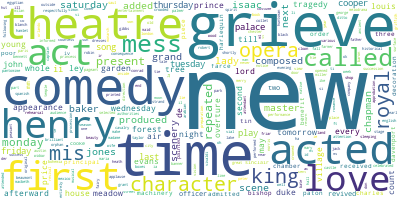

In [51]:
# Create a WordCloud object
wordcloud = WordCloud(stopwords = stop_words, collocations=False, background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [53]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = playbills.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['theatre', 'co', 'present', 'wednesday', 'january', 'acted', 'comedy', 'way', 'brilliant', 'lady', 'muslin', 'time', 'new', 'ana', 'rated', 'called', 'harlequin', 'beauty', 'oh', 'sleeping', 'ee', 'entirely', 'selected', 'auks', 'haul', 'tie', 'tricks', 'principal', 'pantomime', 'characters']


We now convert the documents into a simple vector representation (Bag of Words BOW). Next, we will convert a list of titles into lists of vectors, all with length equal to the vocabulary.

We’ll then plot the ten most frequent words based on the outcome of this operation (the list of document vectors). As a check, these words should also occur in the word cloud.

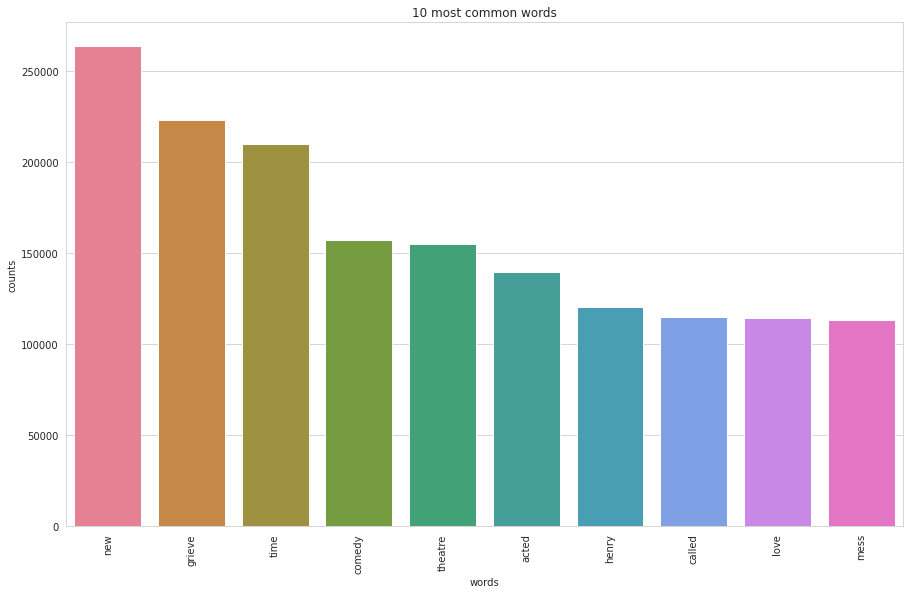

In [54]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
#%matplotlib inline # Helper function

def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(playbills['paper_text_processed'])# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)